# Pipeline for Training & Evaluating model

In [188]:
# %%writefile pipeline.py

import numpy as np
import scipy.io
import sys
import argparse
import os
from time import time
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Merge, Dropout, Reshape
from keras.layers.recurrent import *

from keras.utils import np_utils, generic_utils
from keras.callbacks import ModelCheckpoint, RemoteMonitor
from keras.models import model_from_json
from keras.optimizers import *
from sklearn.externals import joblib
from sklearn import preprocessing

from spacy.en import English

from scripts.utils import grouper, selectFrequentAnswers
from scripts.features import get_answers_matrix, get_questions_tensor_timeseries, get_images_matrix
from models.CNN.VGG import VGG_16
from keras.utils.visualize_util import plot
import pandas as pd

def train(model_structure,
          model_weight,
          model_loss_record_file,
          num_hidden_units_mlp = 1024,
          num_hidden_units_rnn = 512,
          num_hidden_layers_mlp = 3,
          num_hidden_layers_rnn = 1,
          dropout = 0.5,
          activation_mlp = 'tanh',
          num_epochs = 10,
          model_save_interval = 5,
          batch_size = 128,
          model_type = "LSTM",
          optimizer_type = 'rmsprop'):
    '''Training with extracted image features'''
    # Hyper parameters settings: 
    # (word dimension, image dimension, max len of words in question)
    word_vec_dim= 300
    img_dim = 4096
    max_len = 30
    nb_classes = 1000
    #get the data
    questions_train = open('data/preprocessed/questions_train2014.txt', 'r').read().decode('utf8').splitlines()
    questions_lengths_train = open('data/preprocessed/questions_lengths_train2014.txt', 'r').read().decode('utf8').splitlines()
    answers_train = open('data/preprocessed/answers_train2014_modal.txt', 'r').read().decode('utf8').splitlines()
    images_train = open('data/preprocessed/images_train2014.txt', 'r').read().decode('utf8').splitlines()
    vgg_model_path = 'features/coco/vgg_feats.mat'

    max_answers = nb_classes
    questions_train, answers_train, images_train = selectFrequentAnswers(questions_train,answers_train,images_train, max_answers)
    questions_lengths_train, questions_train, answers_train, images_train = (list(t) for t in zip(*sorted(zip(questions_lengths_train, questions_train, answers_train, images_train))))

    #encode the answers
    labelencoder = preprocessing.LabelEncoder()
    labelencoder.fit(answers_train)
    nb_classes = len(list(labelencoder.classes_))
    joblib.dump(labelencoder,'models/labelencoder.pkl')

    #Image Model
    image_model = Sequential()
    image_model.add(Reshape(input_shape = (img_dim,), dims=(img_dim,)))
    
    # Design choice for language model 
    if model_type.lower() == 'lstm':
        RNN = LSTM
    elif model_type.lower() == 'gru':
        RNN = GRU
    # Design choice for optimizor
    if optimizer_type.lower() == "sgd":
        optimizer = SGD(momentum=0.9, nesterov=True)
    elif optimizer_type.lower() == "rmsprop":
        optimizer = RMSprop()
    
    #language model
    language_model = Sequential()
    if num_hidden_layers_rnn == 1:
        language_model.add(RNN(output_dim = num_hidden_units_rnn, return_sequences=False, input_shape=(max_len, word_vec_dim)))
    else:
        language_model.add(RNN(output_dim = num_hidden_units_rnn, return_sequences=True, input_shape=(max_len, word_vec_dim)))
        for i in xrange(num_hidden_layers_rnn-2):
            language_model.add(RNN(output_dim = num_hidden_units_rnn, return_sequences=True))
        language_model.add(RNN(output_dim = num_hidden_units_rnn, return_sequences=False))
    
    #VQA model: merge language model and image model
    model = Sequential()
    model.add(Merge([language_model, image_model], mode='concat', concat_axis=1))
    for i in xrange(num_hidden_layers_mlp):
        model.add(Dense(num_hidden_units_mlp, init='uniform'))
        model.add(Activation(activation_mlp))
        model.add(Dropout(dropout))
    model.add(Dense(nb_classes, activation = "softmax"))

    # Dump the model to file
    json_string = model.to_json()
    open(model_structure, 'w').write(json_string)

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer=optimizer)
    print 'Compilation done'

    # Load the pre extracted features
    features_struct = scipy.io.loadmat(vgg_model_path)
    VGGfeatures = features_struct['feats']

    # Mapping to corresponding image
    image_ids = open('features/coco_vgg_IDMap.txt').read().splitlines()
    img_map = {}
    for ids in image_ids:
        id_split = ids.split()
        img_map[id_split[0]] = int(id_split[1])

    nlp = English()
    print 'loaded word2vec features...'
    
    ## training
    print 'Training started...'
    losses = []
    for k in xrange(num_epochs):
        #progress bar when training
        progbar = generic_utils.Progbar(len(questions_train))

        for qu_batch,an_batch,im_batch in zip(grouper(questions_train, batch_size, fillvalue=questions_train[-1]), 
                                                grouper(answers_train, batch_size, fillvalue=answers_train[-1]), 
                                                grouper(images_train, batch_size, fillvalue=images_train[-1])):
            timesteps = len(nlp(qu_batch[-1])) #questions sorted in descending order of length
            X_q_batch = get_questions_tensor_timeseries(qu_batch, nlp, timesteps)
            X_i_batch = get_images_matrix(im_batch, img_map, VGGfeatures)
            Y_batch = get_answers_matrix(an_batch, labelencoder)
            loss = model.train_on_batch([X_q_batch, X_i_batch], Y_batch)
            losses.append(loss[0].item(0))
            progbar.add(batch_size, values=[("train loss", loss[0].item(0))])

        if k%model_save_interval == 0:
            model.save_weights(model_weight, overwrite=True)

    model.save_weights(model_weight, overwrite=True)
    with open(model_loss_record_file, 'w') as f:
        f.write(",".join(map(str, losses)))
    # %%writefile evaluate_LSTM_group.py




def get_image_model(CNN_weights_file_name):
    ''' Takes the CNN weights file, and returns the VGG model update 
    with the weights. Requires the file VGG.py inside models/CNN '''

    image_model = VGG_16(CNN_weights_file_name)

    # this is standard VGG 16 without the last two layers
    sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    # one may experiment with "adam" optimizer, but the loss function for
    # this kind of task is pretty standard
    image_model.compile(optimizer=sgd, loss='categorical_crossentropy')
    return image_model
    
def get_image_features(image_file_name, CNN_weights_file_name):
    ''' Runs the given image_file to VGG 16 model and returns the 
    weights (filters) as a 1, 4096 dimension vector '''
    image_features = np.zeros((1, 4096)) # Dimension of 4096  Comes from last layer of VGG Model
    
    # VGG is trained in 224 x 224 images - every image will be reshaped to this shape(1, 3, 224, 224)
    im = scipy.misc.imresize(scipy.misc.imread(image_file_name), (224, 224))
    im = im.transpose((2,0,1)) # convert the image to RGBA
    im = np.expand_dims(im, axis=0) 

    image_features[0,:] = get_image_model(CNN_weights_file_name).predict(im)[0]
    return image_features

def get_image_features_batch(image_batch, CNN_weights_file_name):
    batch_size = len(image_batch)
    image_feature_batch = np.zeros((batch_size, 4096))
    for i in range(batch_size):
        image_feature_batch[i,:] = get_image_features(image_batch[i], CNN_weights_file_name)
    return image_feature_batch


def evaluate(model = 'models/lstm_1_num_hidden_units_lstm_512_num_hidden_units_mlp_1024_num_hidden_layers_mlp_3_num_hidden_layers_lstm_1.json',
         weights = 'models/lstm_1_num_hidden_units_lstm_512_num_hidden_units_mlp_1024_num_hidden_layers_mlp_3_num_hidden_layers_lstm_1_epoch_075.hdf5',
           images_dir ='data/evaluate/',
            results = 'results/results.txt'):
    CNN_weights_file_name   = 'models/CNN/vgg16_weights.h5'    
    questions_train = open('data/preprocessed/questions_train2014.txt', 
                        'r').read().decode('utf8').splitlines()
#     questions_lengths_train = open('data/preprocessed/questions_lengths_train2015.txt', 
#                                 'r').read().decode('utf8').splitlines()
    answers_train = open('data/preprocessed/answers_train2014_all.txt', 
                        'r').read().decode('utf8').splitlines()
    image_ids = open('data/preprocessed/images_train2014.txt', 
                        'r').read().decode('utf8').splitlines()
    

            
    # Create mapping from image_id to image_file_path
    image_file_id_Map = {}
    for image_name in os.listdir(images_dir):     
        if image_name[0] != ".":
            coco_id = str(int(image_name[-16:-4]))
            image_file_id_Map[coco_id] = images_dir + image_name
    indexs = []
    for image_id in image_file_id_Map.keys():
        indexs.append(image_ids.index(image_id))
        
    selected_questions = [questions_train[index] for index in indexs]
    selected_answers = [answers_train[index] for index in indexs]
    selected_image_ids = [image_ids[index] for index in indexs]
    
    
    # Create a list image file path same order corresponding with image ids
    image_file_pathes = []
    for image_id in selected_image_ids:
        image_file_pathes.append(image_file_id_Map[image_id])
        
    image_file_pathes, selected_questions, selected_answers,selected_image_ids = (list(t) for t in zip(*sorted(zip(image_file_pathes, selected_questions, selected_answers, selected_image_ids))))


    
    if not os.path.exists("data/feature_dump/image_feature_dump.pkl"):
        print("Image feature file does not exist, let's create one....")
        samplesize = len(image_file_pathes)
        matrix = np.zeros((samplesize, 4096))
        for i in range(samplesize):
            image_file = image_file_pathes[i]
            matrix[i,:] = get_image_features(image_file, CNN_weights_file_name)
        matrix.dump("data/feature_dump/image_feature_dump.pkl") 
    else:
        matrix = np.load("data/feature_dump/image_feature_dump.pkl")
        
    # load the model
    model = model_from_json(open(model).read())
    model.load_weights(weights)
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
    nlp = English()
    
    labelencoder = joblib.load('models/labelencoder.pkl')
    
    # get prediction results and save it in answer_list

    print("Starting evaluation....")
    answer_list = []
    for i, image_file, question in zip(range(len(image_file_pathes)), image_file_pathes, selected_questions):
        if not os.path.exists("data/evaluate/image_feature_dump.pkl"):
            X_i = get_image_features(image_file, CNN_weights_file_name)
        else:
            X_i = matrix[i]
        
        timesteps = len(nlp(question))
        X_q = get_questions_tensor_timeseries([question], nlp, timesteps)

        X = [X_q, X_i]
        y_predict = model.predict(X, verbose=0)
        print image_file
        #for label in reversed(np.argsort(y_predict)[0,-10:]):
            #print str(round(y_predict[0,label]*100,2)).zfill(5), "% ", labelencoder.inverse_transform(label)
        answers = reversed(np.argsort(y_predict)[0,-1:])
        answer_coverage = [labelencoder.inverse_transform(answer) for answer in answers]
        answer_list.append(answer_coverage)
            
    # Calcluate performance       
    total = 0
    correct_val=0.0
    f1 = open(results, 'w')
    for answer_coverage, truth, question, image in zip(answer_list, selected_answers, selected_questions, selected_image_ids):
        temp_count=0
        for _truth in truth.split(';'):
            if _truth in answer_coverage:
                temp_count+=1

        if temp_count>2:
            correct_val+=1
        else:
            correct_val+=float(temp_count)/3

        total+=1

    f1.write(str(correct_val/total))
    f1.close()
    print 'Final Accuracy on the validation set is', correct_val/total

def pipline():
    print("pip line started...")
    df = pd.read_csv("pipeline.csv")

    model_structure = df["model_struct"]
    model_weight = df["model_weight"]
    loss = df["loss"]
    evaluate_output = df["evaluate"]

    print("training pipline")
    print("Start training...")
    start = time()
    train(model_type = "LSTM",optimizer_type = 'rmsprop', model_structure = model_structure[0], model_weight = model_weight[0], model_loss_record_file = loss[0])
    end = time()
    print("training took {0:.2f} minutes".format((end-start)/60))
    print("finished one...")
    start = time()
    train(model_type = "GRU",optimizer_type = 'rmsprop', model_structure = model_structure[1], model_weight = model_weight[1], model_loss_record_file = loss[1])
    end = time()
    print("training took {0:.2f} minutes".format((end-start)/60))
    print("finished one...")
    start = time()
    train(model_type = "LSTM",optimizer_type = 'SGD', model_structure = model_structure[2], model_weight = model_weight[2], model_loss_record_file = loss[2])
    end = time()
    print("training took {0:.2f} minutes".format((end-start)/60))
    print("finished all...")


    evaluate pipline 
    for i in range(len(evaluate_output)):
        evaluate(model = model_structure[i],
                 weights = model_weight[i],
                 results = evaluate_output[i]
                )
    
    
if __name__ == "__main__":
    pipline()

In [23]:
%%writefile pipeline.csv
model_struct,model_weight,loss,evaluate
"models/model1.json","models/model1.hdf5","models/loss1.txt","results/m1.txt"
"models/model2.json","models/model2.hdf5","models/loss2.txt","results/m2.txt"
"models/model3.json","models/model3.hdf5","models/loss3.txt","results/m3.txt"

Overwriting pipeline.csv


## Training

In [170]:

print("pip line started...")
df = pd.read_csv("pipeline.csv")

model_structure = df["model_struct"]
model_weight = df["model_weight"]
loss = df["loss"]
evaluate_output = df["evaluate"]

training pipline
print("Start training...")
train(model_type = "LSTM",optimizer_type = 'rmsprop', model_structure = model_structure[0], model_weight = model_weight[0], model_loss_record_file = loss[0])
print("finished one...")
train(model_type = "GRU",optimizer_type = 'rmsprop', model_structure = model_structure[1], model_weight = model_weight[1], model_loss_record_file = loss[1])
print("finished one...")
train(model_type = "LSTM",optimizer_type = 'SGD', model_structure = model_structure[2], model_weight = model_weight[2], model_loss_record_file = loss[2])
print("finished all...")


pip line started...


## Evaluating

In [192]:
#evaluate pipline 
for i in range(len(evaluate_output)):
    evaluate(model = model_structure[i],
             weights = model_weight[i],
             results = evaluate_output[i]
            )

In [179]:
[float(open(file_i, "r").read().decode('utf8').splitlines()[0])  for file_i in evaluate_output]

[0.219047619048, 0.495238095238, 0.0571428571429]

In [180]:
val = [float(open(file_i, "r").read().decode('utf8').splitlines()[0])  for file_i in evaluate_output]

model_dic = {"model": ["LSTM+RMSprop", "GRU+RMSprop", "LSTM+SGD"],"val":val}
eva_df = pd.DataFrame.from_dict(model_dic)

In [177]:
import pandas as pd
five_ans_vals = {"model": ["LSTM+RMSpop", "GRU+RMSprop", "LSTM+SGD"], "val":[0.542857, 0.495238, 0.076190]}
five_ans_df = pd.DataFrame.from_dict(five_ans_vals)

In [190]:
five_ans_df.to_pickle("five.pkl")

In [178]:
five_ans_df

,model,val
0,LSTM+RMSpop,0.542857
1,GRU+RMSprop,0.495238
2,LSTM+SGD,0.076190


In [182]:
eva_df

,model,val
0,LSTM+RMSprop,0.219048
1,GRU+RMSprop,0.495238
2,LSTM+SGD,0.057143


In [181]:
eva_df.to_pickle("eva.pkl")

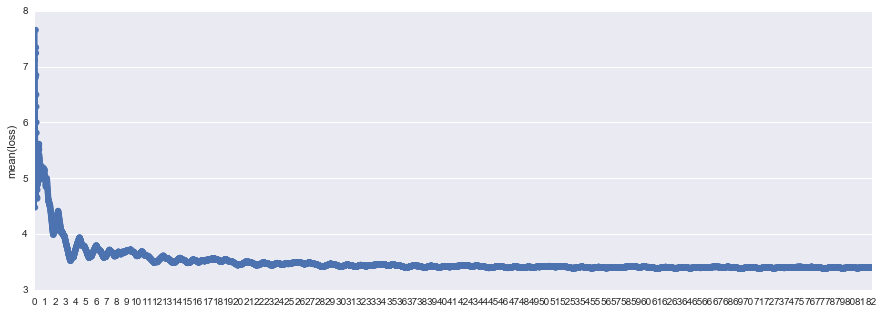

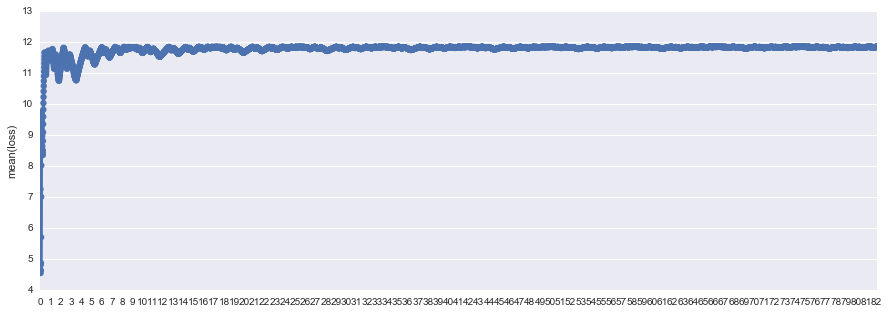

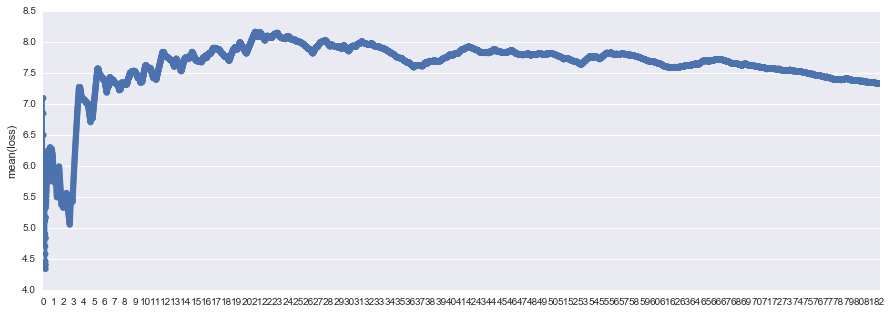

In [193]:
%matplotlib inline
import seaborn as sns


def cumulative_sum(losses):
    cumulative = 0
    running_avg = []

    for i in range(len(losses)):
        cumulative += losses[i]
        running_avg.append(cumulative/float(i+1))
    return running_avg


sns.set_style("darkgrid")

for i in range(len(loss)):
    losses_file = open(loss[i], "r").read()
    losses = map(float, losses_file.split(","))
    loss_df = pd.DataFrame(cumulative_sum(losses), columns=["loss"])
# Show the results of a linear regression within each dataset
    sns.plt.figure(figsize=(15,5))
    sns.pointplot(x = loss_df.index, y="loss", data=loss_df, markers='.')
    sns.plt.xticks(np.arange(min(loss_df.index), max(loss_df.index), 100))
    sns.plt.show()